In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt

import sys
np.set_printoptions(threshold=sys.maxsize)


# Data

In [22]:
df=pd.read_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-2/final/Data_imports/TCS.NS(close).csv')
df.head

<bound method NDFrame.head of             Date  TCS.NS(close)
0     2011-01-03     446.351959
1     2011-01-04     441.225555
2     2011-01-05     446.698761
3     2011-01-06     451.613129
4     2011-01-07     440.416321
...          ...            ...
3199  2023-12-22    3778.896729
3200  2023-12-26    3750.782227
3201  2023-12-27    3766.247559
3202  2023-12-28    3755.080811
3203  2023-12-29    3748.657715

[3204 rows x 2 columns]>

In [23]:
def make_dataset(df,w):
    
    l=int(len(df))
    n=int(0.8*(l-w))

    #for close price
    df_close=df['TCS.NS(close)']
    df_close = df_close.astype(float)
    data_i=np.zeros((l-w,w))

    for i in range (l-w):
        for j in range(w):
            data_i[i][j]=df_close[i+j]

    data_o=np.array([df_close[i+w] for i in range(l-w)])
    data_o=data_o.reshape(l-w,1)

    data=np.column_stack((data_i,data_o))

    #training and validating data
    tv_data=data[:n,:]
    np.random.seed(0)
    np.random.shuffle(tv_data)

    #test data
    test_data=data[n:,:-1]
    act_data=data[n:,-1]
    
    return tv_data,test_data,act_data

In [24]:
def split_dataset(ran_tv_close):
    
    X_close=ran_tv_close[:,:-1]
    y_close=ran_tv_close[:,-1]
    X_train_close, X_val_close, y_train_close, y_val_close = train_test_split(X_close, y_close, test_size=0.2, random_state=0)

    return X_train_close, X_val_close, y_train_close, y_val_close

In [25]:
tv_data,test_data,act_data=make_dataset(df,124)
X_train_close, X_val_close, y_train_close, y_val_close=split_dataset(tv_data)

X_train_close.shape, X_val_close.shape, y_train_close.shape, y_val_close.shape, test_data.shape, act_data.shape

((1971, 124), (493, 124), (1971,), (493,), (616, 124), (616,))

# Model

In [26]:
initalizer2 = keras.initializers.HeNormal

tf.keras.backend.clear_session()

In [27]:
w=124
def model_builder(hp):
  model = keras.Sequential()
  act = hp.Choice('activation', values=['relu','sigmoid', 'tanh'])
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  hl = hp.Int('layers', min_value=2, max_value=6, step=1)
  model.add(Dense(hp_units, input_shape=(w,), activation=act, name = 'Input'))
  for i in range(hl):
    model.add(Dense(units=hp_units, activation=act))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='mse',metrics=['mape'] )
  return model

In [28]:
tuner = kt.Hyperband(model_builder, objective=kt.Objective("val_mape", direction="min"), max_epochs=10, factor=3, directory='tcs124', project_name='intro_to_kt')


Reloading Tuner from tcs124/intro_to_kt/tuner0.json


In [29]:
with tf.device('/CPU:0'):
    tuner.search(X_train_close,y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))
    best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
    model=tuner.hypermodel.build(best_hps)
    print(model.summary())

    history=model.fit(X_train_close, y_train_close, epochs=100, batch_size=25, validation_data=(X_val_close,y_val_close))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (Dense)                   │ (None, 512)            │        64,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,825 (2.25 MB)

 Trainable params: 589,825 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 256111.5469 - mape: 24.5644 - val_loss: 5257.7749 - val_mape: 4.2761
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5412.1025 - mape: 3.9659 - val_loss: 3673.1665 - val_mape: 3.6196
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4390.8013 - mape: 3.5445 - val_loss: 2912.5173 - val_mape: 3.0584
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3831.8264 - mape: 3.3766 - val_loss: 3715.4219 - val_mape: 3.7739
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4023.7661 - mape: 3.5643 - val_loss: 2402.2776 - val_mape: 2.9605
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2979.5125 - mape: 3.0090 - val_loss: 5408.3691 - val_mape: 4.8512
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3253.0383 - mape: 3.2706 - val_loss: 5967.6826 - val_mape: 4.8197
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3767.6770 - mape: 3.4557 - val_loss: 1701.3712 - val_mape:

In [30]:
test_pred=model.predict(test_data)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [31]:
model.save('model_best_tcs124.keras')

In [32]:

#mae and accuracy for test data
def mae_accuracy_test(y_pred_close,act_data):

    mae_close = np.mean(abs(y_pred_close - act_data))

    return mae_close

In [33]:
act_data=act_data.reshape(len(act_data),1)

mae=mae_accuracy_test(test_pred,act_data)
print('mae_test=',mae)

#r2 score for test data
from sklearn.metrics import r2_score
r2=r2_score(act_data,test_pred)
print('r2_test=',r2)

#mape for test data
mape_=np.mean(np.abs((act_data - test_pred) / act_data)) * 100
print('mape_test=',mape_)

#accuracy for test data
acc_test=1-(mae/np.mean(act_data))
print("Accuracy_test=",acc_test)

#root mean square error for test data
from sklearn.metrics import mean_squared_error
rmse_test=np.sqrt(mean_squared_error(act_data,test_pred))
print('rmse_test=',rmse_test)

mae_test= 44.50090997869318
r2_test= 0.9210188637532705
mape_test= 1.3591512931082337
Accuracy_test= 0.9864816111791096
rmse_test= 58.20192640809194


# Plot

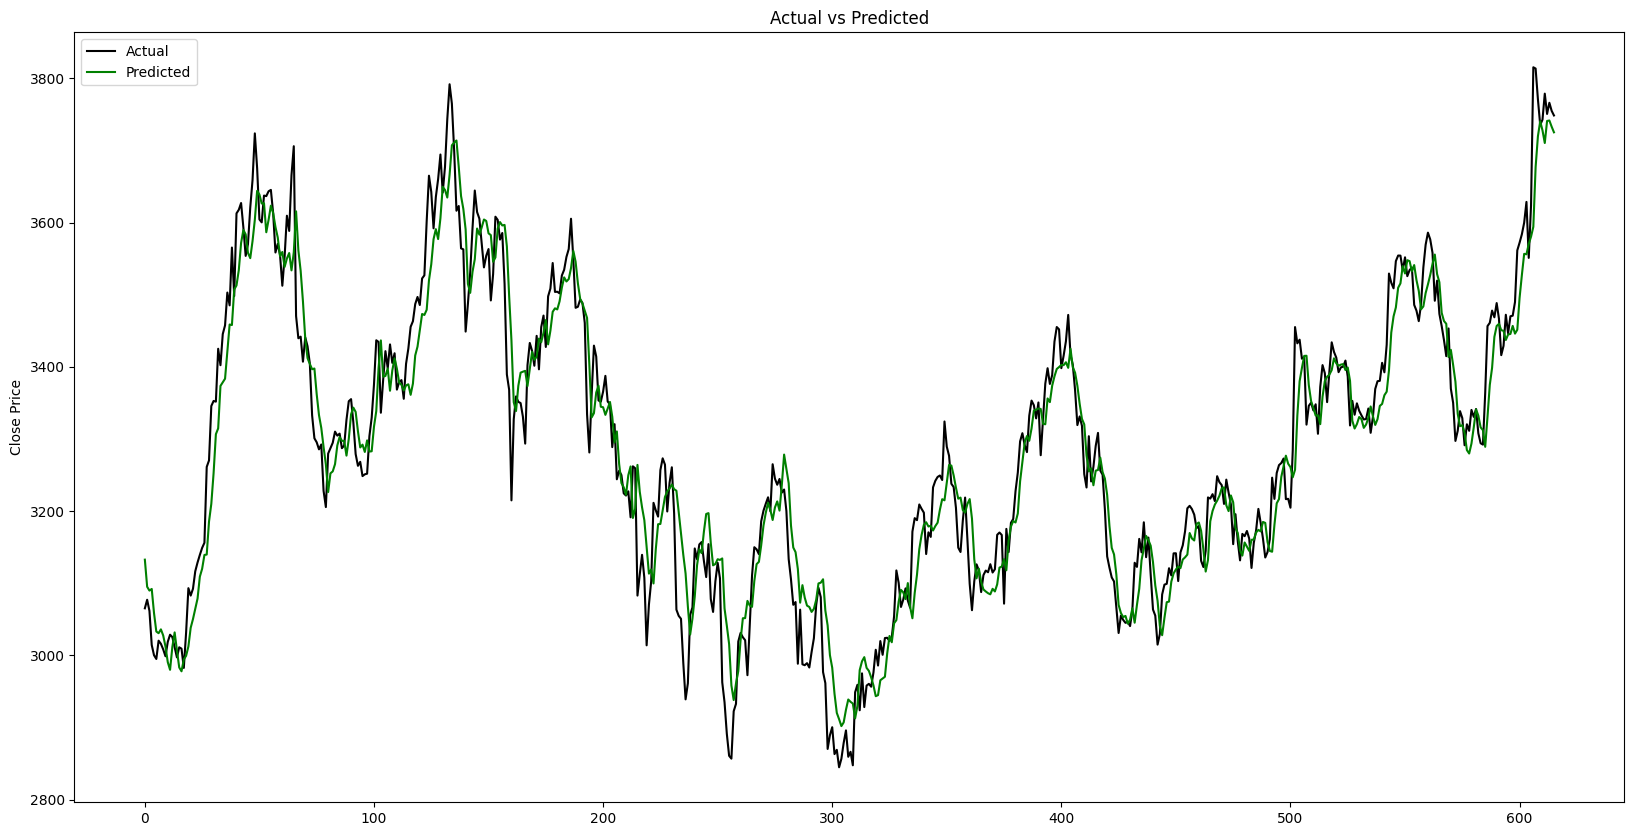

In [34]:
#plot actual vs predicted for test data

plt.figure(figsize=(20,10))
plt.plot(act_data, color = 'black', label = 'Actual')
plt.plot(test_pred, color = 'green', label = 'Predicted')
plt.title('Actual vs Predicted')
plt.ylabel('Close Price')
plt.legend()
plt.show()

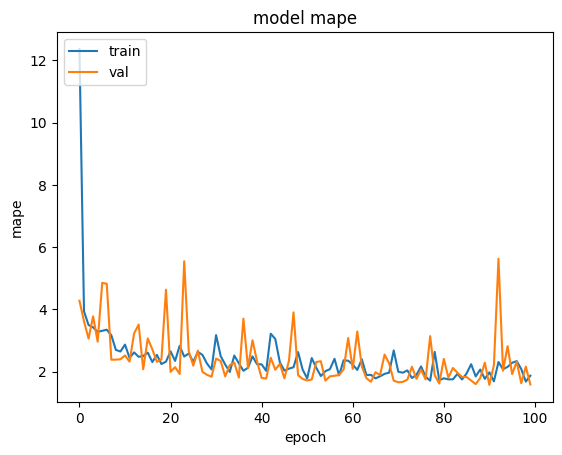

In [35]:
#plot epochs vs mape
plt.plot(history.history['mape'], label='mape')
plt.plot(history.history['val_mape'], label='val_mape')
plt.title('model mape')
plt.ylabel('mape')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [36]:
a=int(len(df))
b=int(0.8*(a-w))
y=b+w

df1=df['TCS.NS(close)']
df_numpy=df1.to_numpy()
new_data=df_numpy[y-1:a-1]
new_data=new_data.reshape(len(new_data),1)

In [37]:
bs=test_pred-new_data
bs
#profit and loss    
def profit_loss(bs):
    n=len(bs)
    profit=0
    loss=0
    for i in range(n-1):
        if bs[i]>0:
            profit=profit+bs[i]
        else:
            loss=loss-bs[i]
    return profit,loss

profit,loss =profit_loss(bs)
profit_factor=profit/loss

print('profit=',profit)
print('loss=',loss)

print('profit=',profit-loss)
print('profit_factor=',profit_factor)



profit= [9088.48583984]
loss= [10115.92016602]
profit= [-1027.43432617]
profit_factor= [0.89843392]


In [38]:
signal=np.array([])

for i in range(len(bs)):
    if bs[i]>0:
        signal=np.append(signal,1)
    else:
        signal=np.append(signal,-1)

signal.reshape(len(signal),1)
df_out = df[['Date', 'TCS.NS(close)']]
df_out_arr = df_out.to_numpy()
trading_signal = np.column_stack((df_out_arr[y:],signal))
trading_signal_df = pd.DataFrame(trading_signal, columns=['Date', 'Close Price', 'Trading Signal'])
trading_signal_df

,Date,Close Price,Trading Signal
0,2021-07-06,3065.270264,1.0
1,2021-07-07,3077.15625,1.0
2,2021-07-08,3061.699463,1.0
3,2021-07-09,3014.390381,1.0
4,2021-07-12,3000.249756,1.0
...,...,...,...
611,2023-12-22,3778.896729,-1.0
612,2023-12-26,3750.782227,-1.0
613,2023-12-27,3766.247559,-1.0
614,2023-12-28,3755.080811,-1.0


In [39]:
trading_signal_df['Date']=pd.to_datetime(trading_signal_df['Date'])
trading_signal_df['Close Price']=trading_signal_df['Close Price'].astype(float)
trading_signal_df['Trading Signal']=trading_signal_df['Trading Signal'].astype(float)

trading_signal_df.dtypes

Date              datetime64[ns]
Close Price              float64
Trading Signal           float64
dtype: object

In [40]:
trading_signal_df.to_csv('/Users/vedantgupta/Documents/summer project/data-analysis-with-technical-indicators-2/final/trading_signals/tcs124_nn_ts.csv',index=False)